# Sample use of the sun topic model 

In [11]:
import numpy as np
from sun_topicmodel import suntopic
import matplotlib.pyplot as plt
import pandas as pd

coeff_true: [-0.14839787  0.62329141 -0.13965751 -0.8448346  -2.10694246 -0.32659849
 -0.23407879  0.20232527 -0.95363785 -0.32258843]


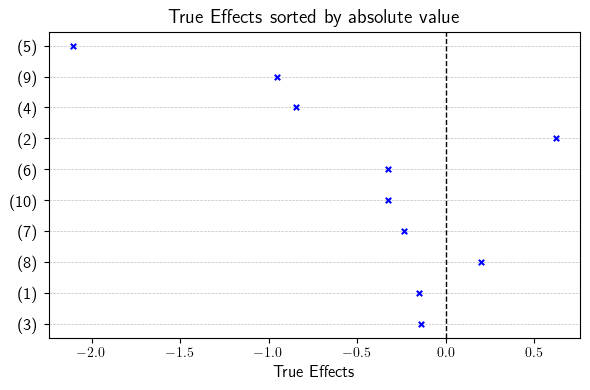

In [38]:
# Generate random data as the 'embeddings' for the 'documents' in the corpus
np.random.seed(2024)
n = 2000
m = 100
J = 10
W_t = np.random.rand(n, J)
H_t = np.random.rand(J, m)
X = np.dot(W_t, H_t) + np.random.rand(n, m) * 0.1
coef_true = np.random.normal(0, 1, J)
Y = np.dot(W_t, coef_true) + np.random.rand(n) * 0.1
Y = (Y-np.mean(Y))/np.std(Y)
print(f"coeff_true: {coef_true}")

sorted_indices = np.argsort(np.abs(coef_true))[::-1]
sorted_coef_true = coef_true[sorted_indices]

# Set font to Computer Modern
plt.rcParams["text.usetex"] = True

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

for i, param in enumerate(sorted_coef_true):
    ax.axhline(i, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.scatter(param, i, marker="x", s=15, color="blue", zorder=10)


# Customize the plot
ax.axvline(0, color="black", linestyle="--", linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(sorted_coef_true)))
ax.set_yticklabels([f"({i+1})" for i in sorted_indices], fontsize=12)
ax.set_xlabel("True Effects", fontsize=12)
ax.set_title("True Effects sorted by absolute value", fontsize=14)

# Save or show the plot
plt.tight_layout()
plt.show()

In [39]:
# do train, estimation split
X_train = X[:1500, :]
X_est = X[1500:, :]
Y_train = Y[:1500]
Y_est = Y[1500:]

# Initialize and fit the model
model = suntopic(Y=Y_train, X=X_train, alpha=0.5, num_bases=3, random_state=2024)
model.fit()
model.summary()

Suntopic Model Summary
Number of topics:  3
Alpha:  0.5
Data shape:  (1500, 101)
Model:  <sun_topicmodel.snmf.SNMF object at 0x30d985650>
Random initialization state:  2024
Prediction coefficients:  [-0.52014434  0.51228163  0.03410524]
In-sample MSE:  0.6968719376902164


In [40]:
# Initialize and fit the model
model = suntopic(Y=Y_train, X=X_train, alpha=0.1, num_bases=3, random_state=2024)
model.fit()
model.summary()

Suntopic Model Summary
Number of topics:  3
Alpha:  0.1
Data shape:  (1500, 101)
Model:  <sun_topicmodel.snmf.SNMF object at 0x30d8ab8d0>
Random initialization state:  2024
Prediction coefficients:  [-0.20001899  1.67498806 -1.31653666]
In-sample MSE:  0.0494208002939115


In [41]:
# Use cross validation for finding optimal hyperparameters: number of bases and alpha
model.hyperparam_cv(
    alpha_range=np.linspace(0.1, 0.9, 9),
    num_bases_range=np.arange(2, 10),
    cv_folds=5,
    random_state=2024,
)
model.cv_summary()

Cross-Validation Summary
Alpha candidate values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Number of topics:  [2 3 4 5 6 7 8 9]
Number of folds:  5
CV Random state:  2024
Top 1 hyperparam combinations - num_bases: 7.00, alpha: 0.20, MSE: 0.5628
Top 2 hyperparam combinations - num_bases: 6.00, alpha: 0.50, MSE: 0.5983
Top 3 hyperparam combinations - num_bases: 7.00, alpha: 0.60, MSE: 0.6138


In [43]:
# Use parallelization to speed up the hyperparameter search
model.hyperparam_cv(
    alpha_range=np.linspace(0.1, 0.9, 9),
    num_bases_range=np.arange(2, 10),
    cv_folds=5,
    random_state=2024,
    parallel=True,
)
model.cv_summary()

Cross-Validation Summary
Alpha candidate values:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Number of topics:  [2 3 4 5 6 7 8 9]
Number of folds:  5
CV Random state:  2024
Top 1 hyperparam combinations - num_bases: 7.00, alpha: 0.20, MSE: 0.5628
Top 2 hyperparam combinations - num_bases: 6.00, alpha: 0.50, MSE: 0.5983
Top 3 hyperparam combinations - num_bases: 7.00, alpha: 0.60, MSE: 0.6138


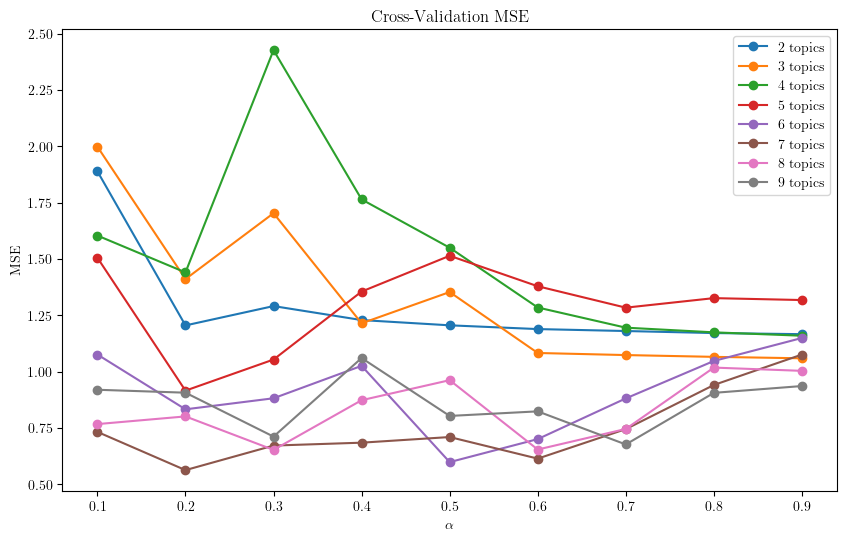

In [44]:
model.cv_mse_plot()

In [46]:
# Initialize and fit the model with best hyperparameters
model = suntopic(Y=Y_train, X=X_train, alpha=0.2, num_bases=7, random_state=2024)
model.fit()
model.summary()

Suntopic Model Summary
Number of topics:  7
Alpha:  0.2
Data shape:  (1500, 101)
Model:  <sun_topicmodel.snmf.SNMF object at 0x30aeebdd0>
Random initialization state:  2024
Prediction coefficients:  [ 0.08105593  0.09851924 -0.98871563 -1.21767286  0.50802721 -1.29261307
  3.32132295]
In-sample MSE:  0.015424563401533191


# Estimate AMCE 

In [47]:
import statsmodels.api as sm

In [48]:
Y_est_pred, W_est = model.predict(X_est, return_topics=True, random_state=2024)
print(f"{W_est.shape = }")

# Fit a linear regression model to the estimated topics
W_est = sm.add_constant(W_est)
model_est = sm.OLS(Y_est, W_est).fit()
print(model_est.summary())

W_est.shape = (500, 7)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     317.0
Date:                Mon, 06 May 2024   Prob (F-statistic):          8.49e-178
Time:                        15:09:26   Log-Likelihood:                -309.95
No. Observations:                 500   AIC:                             635.9
Df Residuals:                     492   BIC:                             669.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9316      0.

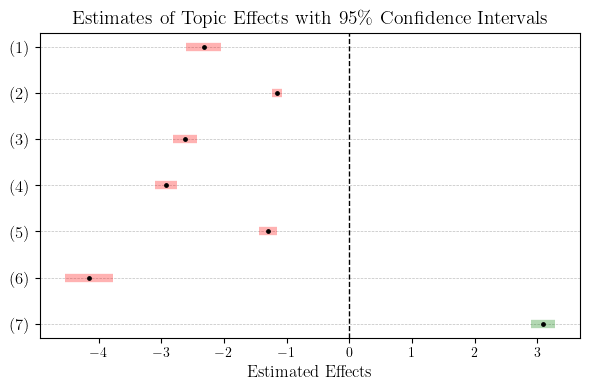

In [49]:
import matplotlib.pyplot as plt
from matplotlib import rc


# Set font to Computer Modern
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rcParams["text.usetex"] = True

# Extract parameters and confidence intervals from the regression results
params = model_est.params[1:]
conf_int = model_est.conf_int()[1:]

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

for i, (param, (lower, upper)) in enumerate(zip(params, conf_int)):
    # Add horizontal lines between rows
    ax.axhline(i, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

    if lower <= 0 & 0 <= upper:
        ax.plot(
            [lower, upper],
            [i, i],
            color="lightgray",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.7,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

    elif lower <= 0 & 0 >= upper:
        ax.plot(
            [lower, upper],
            [i, i],
            color="red",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.3,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

    else:
        ax.plot(
            [lower, upper],
            [i, i],
            color="green",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.3,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

# Customize the plot
ax.axvline(0, color="black", linestyle="--", linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels([f"({i+1})" for i in range(len(model_est.params) - 1)], fontsize=12)
ax.set_xlabel("Estimated Effects", fontsize=12)
# include lin break in the title
ax.set_title("Estimates of Topic Effects with 95\% Confidence Intervals", fontsize=14)


# Save or show the plot
plt.tight_layout()
# plt.savefig( str(data_dir) + '/LinWood_Causal_Effects_plot2.png',bbox_inches="tight", dpi=600)  # Save the plot as an image file
plt.show()